# AutoRegression Model

## Import, handle missing values, create a clean dataframe

In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from statsmodels.tsa.ar_model import AutoReg

ic = pd.read_excel("D:\DS\Mine\Corona\I21-11.xlsx", index_col=0, parse_dates=[0]) # Iran Corona for 2021-11-..
ic['total_vaccinations_f'] = ic['total_vaccinations'].interpolate(method='linear')
ic['stringency_index_f'] = ic['stringency_index'].fillna(method="ffill")
icf = ic.loc[ : , ['datei', 'total_cases', 'new_cases', 'new_cases_smoothed',
                   'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_vaccinations_f', 'stringency_index_f']]

icf.loc[:, "datei"] = icf["datei"].apply(lambda x: x - 43880)
pd.options.display.float_format = '{:,.2f}'.format
# pd.set_option('display.max_rows', 2000)
icf

,datei,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_vaccinations_f,stringency_index_f
date,,,,,,,,,
2020-02-19,0,2,2,NaN,2,2,NaN,0.00,0.00
2020-02-20,1,5,3,NaN,2,0,NaN,0.00,2.78
2020-02-21,2,18,13,NaN,4,2,NaN,0.00,2.78
2020-02-22,3,28,10,NaN,5,1,NaN,0.00,11.11
2020-02-23,4,43,15,NaN,8,3,NaN,0.00,11.11
...,...,...,...,...,...,...,...,...,...
2021-11-24,644,6092822,4813,"4,989.86",129280,103,107.00,"102,145,229.00",69.91
2021-11-25,645,6097672,4850,"4,842.43",129376,96,106.00,"102,145,229.00",69.91
2021-11-26,646,6102056,4384,"4,642.43",129462,86,104.00,"102,145,229.00",69.91


<AxesSubplot:xlabel='date'>

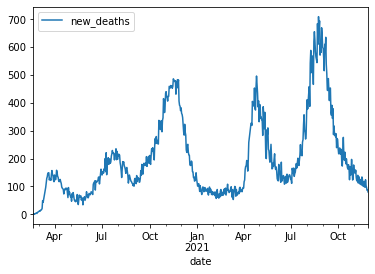

In [112]:
icf.plot(y='new_deaths')

## Defining constants, spliting train and test for AR to predict 7 new_deaths values

In [113]:
length = icf.shape[0]                      #Number of samples
train_len = math.floor(0.90 * length)      #Of entire data for training
test_len = length - train_len              #The rest for actual test 
prl = 7                                    #prediction lendth: number of days to predict

#Focus on new_deaths (index 5):
xr = icf.iloc[ :train_len, 5]                          #XTrain
xs = icf.iloc[train_len : train_len + prl, 5]          #XTest
print('Out of', length, 'samples,', train_len, 'samples are devoted to training section and', test_len, 'to test section.')
xr, xs

Out of 649 samples, 584 samples are devoted to training section and 65 to test section.


(date
 2020-02-19      2
 2020-02-20      0
 2020-02-21      2
 2020-02-22      1
 2020-02-23      3
              ... 
 2021-09-20    344
 2021-09-21    379
 2021-09-22    286
 2021-09-23    317
 2021-09-24    284
 Name: new_deaths, Length: 584, dtype: int64,
 date
 2021-09-25    290
 2021-09-26    278
 2021-09-27    289
 2021-09-28    239
 2021-09-29    272
 2021-09-30    268
 2021-10-01    235
 Name: new_deaths, dtype: int64)

## Quick autocorrelation check

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

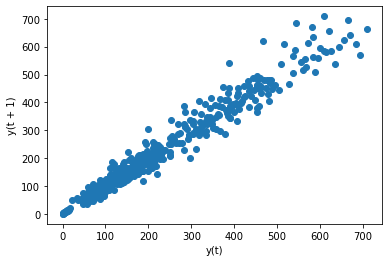

In [114]:
from pandas.plotting import lag_plot
lag_plot(xr)

**>> A high correlation between y(t) and y(t+1) can be seen which is implying that AR can perform well on the dataset.**

## Observation of number of Lags to consider

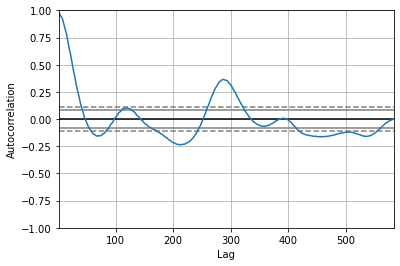

In [115]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(xr)
pyplot.show()

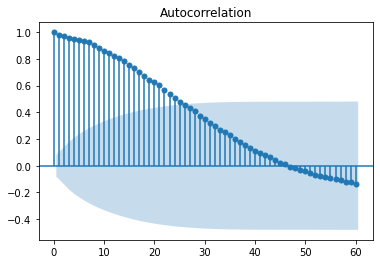

In [116]:
# A more detailed view up to 60 lags only
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(xr, lags=60)
pyplot.show()

**>> So not more than 50 lags is expected to be useful for autoregression.**

## Running AR using lags = 3

In [117]:
xr.index = pd.DatetimeIndex(xr.index.values, freq=xr.index.inferred_freq)
arm = AutoReg(endog=xr, lags=3, old_names=False)
arm_fit = arm.fit()
print('The fit parameters are:')
arm_fit.params

The fit parameters are:


const           3.66
new_deaths.L1   0.70
new_deaths.L2   0.20
new_deaths.L3   0.09
dtype: float64

In [118]:
xsp = arm_fit.predict(start=train_len, end=train_len+prl-1)  #XTest prediction values
for i in range(prl):
    print('Actual =', xs[i], '- predicted =', "{:2.1f}".format(xsp[i]))

Actual = 290 - predicted = 290.2
Actual = 278 - predicted = 290.8
Actual = 289 - predicted = 289.5
Actual = 239 - predicted = 289.2
Actual = 272 - predicted = 288.9
Actual = 268 - predicted = 288.4
Actual = 235 - predicted = 288.0


### Metrics to measure performance

In [119]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
mae = mean_absolute_error(xs, xsp)
mape = mean_absolute_percentage_error(xs, xsp)
rmse = math.sqrt(mean_squared_error(xs, xsp))
print('MAE:  Mean Absolute Error =           ', "{:2.2f}".format(mae))
print('MAPE: Mean Absolute Percentage Error =', "{:2.2f}".format(mape))
print('RMSE: Root Mean Squared Error =       ', "{:2.2f}".format(rmse))

MAE:  Mean Absolute Error =            22.01
MAPE: Mean Absolute Percentage Error = 0.09
RMSE: Root Mean Squared Error =        29.77


## Search to find the best number for parameter "lags"

In [120]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# param = {"lags": [3, 7, 10, 15, 20, 30, 40, 50]}
param = {"lags": range(1, 50)}
lowest_rmse, best_cfg = float("inf"), None

for i in range(len(param["lags"])):
    arm = AutoReg(endog=xr, lags=param["lags"][i], old_names=False)
    arm_fit = arm.fit()
    xsp = arm_fit.predict(start=len(xr), end=len(xr)+prl-1)
    rmse = math.sqrt(mean_squared_error(xs, xsp))
#     mae = mean_absolute_error(xs, xsp)
#     print('Lags =', param['lags'][i])
#     print(": ", arm_fit.params)
#     print('MAE, RMSE:', mae, ',', rmse)
    if lowest_rmse > rmse:
        lowest_rmse, best_cfg = rmse, param["lags"][i]
    
print('\nLowest RMSE', "{:2.2f}".format(lowest_rmse), 'was acheived using lags =', best_cfg)


Lowest RMSE 18.32 was acheived using lags = 9


## Conclusion

**>> The above search and assessment of the models showed that at lags = 9, we have the best performance of AR. The model was fit using 90% of dataset as training data. The assessment was done using 7 consecutive days followed after the initial 90% of data. To improve the search and assessment mechanism, it can be carried out on more spots of the dataset using the same found parameters or using new fit parameters. The length of prediction may also be changed.**

**Several attempts were made to implement the abovementioned searching and assessment techniques. However, as it unnecessarily introduces useless complication to the studies at this stage, they are not mentioned in this notebook.**

**The model shows an acceptable performance within a week after the final available data. This is based on the previous data of the studied feature (autoregression). Also as we are using the local data only, it cannot predict new peaks in cases/deaths. This limits the application of AR to short term predictions (such as 1 or 2 weeks).**